In [154]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import sys, os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_class_weight

from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
stop = stopwords.words('english')

from catboost import CatBoostClassifier, Pool
import spacy

import optuna
from optuna.samplers import TPESampler

!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

seed = 42
np.random.seed(seed)
clear_output()

In [14]:
!pip install -qq spacy

In [42]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    return text

def cross_validation(clf, X, y, scoring='f1', cv=5):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}') 
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))
    
def preprocessor(text, stop=stop):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower())
    text = re.sub(r'[^\w]', ' ', text)
    text = [w for w in text.split() if w not in stop]
    text = [re.sub(r"[^a-zA-Z0-9]+", '', k) for k in text]
    return re.sub(' +', ' ', ' '.join(text))

def snow_stem(text):
    snow_stemmer = SnowballStemmer(language='english')
    new_text = ''
    for word in text.split():
        new_text += snow_stemmer.stem(word) + ' '
    return new_text

def lemmatize(text, nlp=nlp):
    new_text = ''
    for token in nlp(text):
        new_text += token.lemma_ + ' '
    return new_text

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
labels2int = {'fake': 1, 'true': 0}
int2labels = {1: 'fake', 0: 'true'}

In [5]:
fake = pd.read_csv('Fake.csv')
truth = pd.read_csv('True.csv')

'''
fake.text.str.len().hist()
'''
Заголовки и текст в лживых публикациях более длинные 

In [6]:
fake['target'] = 1
truth['target'] = 0

df = pd.concat([fake, truth], axis=0).sample(frac=1).reset_index(drop=True)
df.head()

,title,text,subject,date,target
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


In [116]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df[['title', 'target']].sample(2).values

array([['Belgian judge to decide on ex Catalan leader arrest warrant by Monday',
        0],
       ['BLACK LAWYER, Editor Of Legal Website Writes: Black Jurors Should Automatically Vote To Free Any Black Person Accused Of Murdering, Committing Crime Against A White Person Regardless Of Evidence',
        1]], dtype=object)

In [91]:
df.groupby('subject')['target'].mean()
# we won't take 'subject' into account as this feature leeds to target leakage

subject
Government News    1.0
Middle-east        1.0
News               1.0
US_News            1.0
left-news          1.0
politics           1.0
politicsNews       0.0
worldnews          0.0
Name: target, dtype: float64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [75]:
df['subject'].describe()

count            44898
unique               8
top       politicsNews
freq             11272
Name: subject, dtype: object

In [503]:
from wordcloud import WordCloud

fake_titles = df.loc[df['target'] == 1, 'title'].str.cat(sep='\n')
true_titles = df.loc[df['target'] == 0, 'title'].str.cat(sep='\n')

wordcloud_fake = WordCloud(collocation_threshold=2, 
                           collocations=True, 
                           background_color='white',
                           stopwords=stop,
                           colormap='afmhot').generate(fake_titles)

wordcloud_true = WordCloud(collocation_threshold=2, 
                           collocations=True, 
                           background_color='white',
                           stopwords=stop,
                           colormap='afmhot').generate(true_titles)

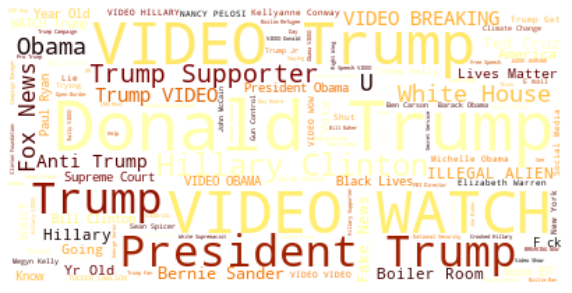

In [505]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()
# looks like every news where Trump or Video occure are ment to be fake :) - meet US freedom of speech :) 

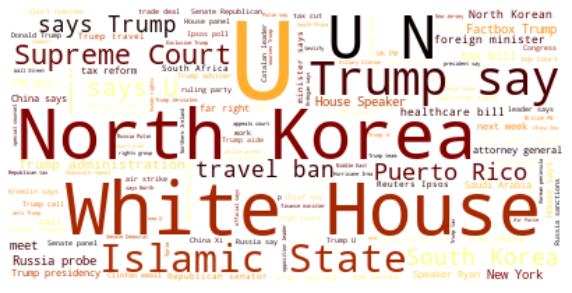

In [506]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis("off")
plt.show()
# news about North Korea and White House statements are true. Ok, let's assume that :) 

#### We will apply Preprocessor+TfidfVectorizer+LogisticRegression or #CatBoost pipeline to title and BertCNN model for text input

#### Finally we will define a class that takes title or/and text, preprocess it with Preprocessor/bert_preprocessor and predict label via LogisticRegressin/CatBoost (title) pipeline or by BertCNN (text) and outputs the prediction label and it's confidence

In [40]:
df['target'].value_counts(normalize=True)
# незначительный дисбаланс, можно обойтись параметром class_weight или попробовать без него

1    0.522985
0    0.477015
Name: target, dtype: float64

In [147]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, stop=None, nlp=None, lemma=True, verbose=False):
        self.stop = stop
        self.nlp = nlp
        if stop is None:
            stop = stopwords.words('english')
        if nlp is None:
            nlp = spacy.load('en_core_web_sm')
        self.lemma = lemma
        self.verbose = verbose
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        if isinstance(X_, pd.Series) and X_.name == 'title':
            if self.verbose:
                print('Applying title tranformations')
            X_ = X_.apply(lambda x: preprocessor(x, stop=self.stop))
            if self.lemma:
                X_ = X_.apply(lambda x: lemmatize(x, nlp=self.nlp))
            else:
                X_ = X_.apply(lambda x: snow_stem(x)) 
        elif isinstance(X_, pd.DataFrame) and ('title' in X_.columns): 
            if self.verbose:
                print('Applying text tranformations')
            X_['title'] = X_['title'].apply(lambda x: preprocessor(x, stop=self.stop))
            if self.lemma:
                X_['title'] = X_['title'].apply(lambda x: lemmatize(x, nlp=self.nlp))
            else:
                X_['title'] = X_['title'].apply(lambda x: snow_stem(x))
        elif isinstance(X_, pd.DataFrame) and ('text' in X_.columns):
            if self.verbose:
                print('Applying text transformations')
            X_['text'] = X_['text'].apply(lambda x: preprocessor(x, stop=self.stop))
            if self.lemma:
                X_['text'] = X_['text'].apply(lambda x: lemmatize(x, nlp=self.nlp))
            else:
                X_['text'] = X_['text'].apply(lambda x: snow_stem(x))
        elif isinstance(X_, pd.Series) and X_.name == 'text':
            if self.verbose:
                print('Applying title tranformations')
            X_ = X_.apply(lambda x: preprocessor(x, stop=self.stop))
            if self.lemma:
                X_ = X_.apply(lambda x: lemmatize(x, nlp=self.nlp))
            else:
                X_ = X_.apply(lambda x: snow_stem(x)) 
        else:
            raise ValueError(f'Input name should be "title" or "text", actual name is {X_.name}')
        return X_

In [515]:
X, y = df['title'], df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=seed)
print(f'Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}.')

Train size: 31428, Test size: 13470.


In [70]:
%%time
pipe = make_pipeline(Preprocessor(stop=stop, nlp=nlp),
                     TfidfVectorizer(lowercase=False, max_features=2500),
                     LogisticRegression(class_weight=None, C=10.0, random_state=seed), verbose=True).fit(X_train, y_train)

[Pipeline] ...... (step 1 of 3) Processing preprocessor, total= 1.6min
[Pipeline] ... (step 2 of 3) Processing tfidfvectorizer, total=   0.2s
[Pipeline]  (step 3 of 3) Processing logisticregression, total=   0.1s
CPU times: total: 1min 36s
Wall time: 1min 36s


In [71]:
%%time
train_pred = pipe.predict(X_train)
test_pred = pipe.predict(X_test)

train_probs = pipe.predict_proba(X_train)[:,1]
test_probs = pipe.predict_proba(X_test)[:,1]

report(y_train, train_pred, y_test, test_pred, train_probs, test_probs)

Train
               precision    recall  f1-score   support

           0      0.957     0.963     0.960     14992
           1      0.966     0.961     0.964     16436

    accuracy                          0.962     31428
   macro avg      0.962     0.962     0.962     31428
weighted avg      0.962     0.962     0.962     31428

Test
               precision    recall  f1-score   support

           0      0.929     0.938     0.934      6425
           1      0.943     0.935     0.939      7045

    accuracy                          0.937     13470
   macro avg      0.936     0.937     0.936     13470
weighted avg      0.937     0.937     0.937     13470

Train ROC_AUC: 0.994, Test ROC_AUC: 0.985
Confusion Matrix 
 col_0      0     1
target            
0       6029   396
1        459  6586
CPU times: total: 4min 38s
Wall time: 4min 38s


In [72]:
precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380206, F-Score=0.940, Precision=0.926, Recall=0.956


### The next approach with CatBoost

In [8]:
from catboost.utils import get_gpu_device_count
print('I see %i GPU devices' % get_gpu_device_count())

I see 1 GPU devices


In [516]:
X, y = pd.DataFrame(data=df['title'].values.reshape(-1,1), columns=['title']), df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, stratify=y_train,
                                                      random_state=seed)
print(f'Train size: {X_train.shape[0]}, validation size: {X_valid.shape[0]}, Test size: {X_test.shape[0]}.')

Train size: 28622, validation size: 5051, Test size: 11225.


In [517]:
text_cols = ['title']
cat_cols = ['subject']

train_pool = Pool(X_train, y_train, text_features=text_cols)
valid_pool = Pool(X_valid, y_valid, text_features=text_cols)

In [10]:
params_model = {
    'eval_metric': 'Accuracy', 
    'iterations': 2000,
    'objective': 'Logloss',
    'silent': True,
    'od_type': 'Iter',
    'od_wait': 50,
    'allow_writing_files': False,
    'use_best_model': True,
    'bootstrap_type': 'MVS',
    'task_type': 'CPU',
    'random_seed': seed,
    'tokenizers': [{'tokenizer_id': 'Sense', 'separator_type': 'BySense', 'lowercasing': 'True', 
                    'token_types': ['Word', 'Number', 'SentenceBreak'], 'sub_tokens_policy': 'SeveralTokens'}],
    'dictionaries': [{'dictionary_id': 'Word', 'max_dictionary_size': '50000', 'token_level_type': 'Word', 
                     'dictionary_type': 'Bpe', 'num_bpe_units': '100'}],
    'feature_calcers': ['BoW:top_tokens_count=10000'],
    }

In [11]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['None', 'Balanced', 'SqrtBalanced']),
                    'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
                    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 255),
                    'max_leaves': trial.suggest_int('max_leaves', 5, 64),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
                    }
    param_trials.update(params_model)
    if param_trials['task_type'] == 'GPU':
        param_trials['boosting_type'] == 'Plain'
    if param_trials['grow_policy'] == 'SymmetricTree':
        param_trials['min_data_in_leaf'] = None
        param_trials['max_leaves'] = None
    if param_trials['grow_policy'] == 'Depthwise':
        param_trials['max_leaves'] = None
    if param_trials['grow_policy'] != 'SymmetricTree':
        param_trials['boosting_type'] = 'Plain'

    opt_model = CatBoostClassifier(**param_trials)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred = opt_model.predict(X_valid)
    score = accuracy_score(y_valid, y_pred)
    
    return score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=100, timeout=600, n_jobs=-1)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2022-05-15 20:41:16,327] A new study created in memory with name: no-name-0a9155e6-357b-4e98-ad4e-09169ecd4a2d
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger

#### Base

In [11]:
%%time
cat = CatBoostClassifier(verbose=0).fit(train_pool, eval_set=valid_pool)

cat_train_pred = cat.predict(X_train)
cat_test_pred = cat.predict(X_test)
cat_train_probs = cat.predict_proba(X_train)[:,1]
cat_test_probs = cat.predict_proba(X_test)[:,1]

report(y_train, cat_train_pred, y_test, cat_test_pred, cat_train_probs, cat_test_probs)

Train
               precision    recall  f1-score   support

           0      0.999     1.000     0.999     13654
           1      1.000     0.999     0.999     14968

    accuracy                          0.999     28622
   macro avg      0.999     0.999     0.999     28622
weighted avg      0.999     0.999     0.999     28622

Test
               precision    recall  f1-score   support

           0      0.995     0.997     0.996      5354
           1      0.997     0.996     0.996      5871

    accuracy                          0.996     11225
   macro avg      0.996     0.996     0.996     11225
weighted avg      0.996     0.996     0.996     11225

Train ROC_AUC: 1.000, Test ROC_AUC: 1.000
Confusion Matrix 
 col_0      0     1
target            
0       5338    16
1         26  5845
CPU times: total: 8min 12s
Wall time: 52.1 s


In [98]:
cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'text_processing': {'dictionaries': [{'start_token_id': '0',
    'occurrence_l

### Tunned

In [518]:
# all parameters
params_model = {
    'eval_metric': 'Accuracy', 
    'iterations': 2000,
    'objective': 'Logloss',
    'silent': True,
    'one_hot_max_size': 5,
    'allow_writing_files': False,
    'use_best_model': True,
    'bootstrap_type': 'Bernoulli',
    'task_type': 'CPU', 
    'boosting_type': 'Plain', # Ordered
    'random_seed': seed,
    'depth': 6, 
    'learning_rate': 0.32296663382388097, 
    'l2_leaf_reg': 1.5401290315719907, 
    'subsample': 0.897822552091148, 
    'auto_class_weights': 'Balanced', 
    'grow_policy': 'Lossguide', 
    'min_data_in_leaf': 71, 
    'max_leaves': 23,
    'od_type': 'Iter',
    'od_wait': 50,
    'text_processing': {'dictionaries': [{'start_token_id': '0',
                                          'occurrence_lower_bound': '5',
                                          'skip_step': '0',
                                          'end_of_word_token_policy': 'Insert',
                                          'token_level_type': 'Word',
                                          'end_of_sentence_token_policy': 'Skip',
                                          'gram_order': '2',
                                          'max_dictionary_size': '50000',
                                          'dictionary_id': 'BiGram'},
                                         {'start_token_id': '0',
                                          'dictionary_type': 'Bpe',
                                          'occurrence_lower_bound': '5',
                                          'skip_step': '0',
                                          'end_of_word_token_policy': 'Insert',
                                          'token_level_type': 'Word',
                                          'end_of_sentence_token_policy': 'Skip',
                                          'gram_order': '1',
                                          'max_dictionary_size': '50000',
                                          'dictionary_id': 'Word'}],
                        'feature_processing': {'default': [{'dictionaries_names': ['BiGram', 'Word'],
                                                            'feature_calcers': ['BoW:top_tokens_count=10000'],
                                                             'tokenizers_names': ['Space']},
                                                            {'dictionaries_names': ['Word'],
                                                             'feature_calcers': ['NaiveBayes'],
                                                             'tokenizers_names': ['Space']}]},
                        'tokenizers': [{'number_token': 'BySense',
                                        'skip_empty': '1',
                                        'number_process_policy': 'LeaveAsIs',
                                        'tokenizer_id': 'Space',
                                        'token_types': ['Number', 'Unknown', 'Word'],
                                        'delimiter': ' ',
                                        'languages': [],
                                        'lemmatizing': '0',
                                        'split_by_set': '0',
                                        'lowercasing': '0',
                                        'subtokens_policy': 'SeveralTokens',
                                        'separator_type': 'ByDelimiter'}]} 
}

In [519]:
%%time
cat_tuned = CatBoostClassifier(**params_model).fit(train_pool, eval_set=valid_pool)

catt_train_pred = cat_tuned.predict(X_train)
catt_test_pred = cat_tuned.predict(X_test)
catt_train_probs = cat_tuned.predict_proba(X_train)[:,1]
catt_test_probs = cat_tuned.predict_proba(X_test)[:,1]

report(y_train, catt_train_pred, y_test, catt_test_pred, catt_train_probs, catt_test_probs)

Train
               precision    recall  f1-score   support

           0      1.000     1.000     1.000     13654
           1      1.000     1.000     1.000     14968

    accuracy                          1.000     28622
   macro avg      1.000     1.000     1.000     28622
weighted avg      1.000     1.000     1.000     28622

Test
               precision    recall  f1-score   support

           0      0.997     0.998     0.997      5354
           1      0.998     0.997     0.997      5871

    accuracy                          0.997     11225
   macro avg      0.997     0.997     0.997     11225
weighted avg      0.997     0.997     0.997     11225

Train ROC_AUC: 1.000, Test ROC_AUC: 1.000
Confusion Matrix 
 col_0      0     1
target            
0       5341    13
1         18  5853
CPU times: total: 3min 32s
Wall time: 16.7 s


In [520]:
precision, recall, thresholds = precision_recall_curve(y_test, catt_test_probs)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.441733, F-Score=0.998, Precision=0.998, Recall=0.998


In [521]:
print(classification_report(y_test, catt_test_probs >= thresholds[ix], digits=4))

              precision    recall  f1-score   support

           0     0.9974    0.9976    0.9975      5354
           1     0.9978    0.9976    0.9977      5871

    accuracy                         0.9976     11225
   macro avg     0.9976    0.9976    0.9976     11225
weighted avg     0.9976    0.9976    0.9976     11225



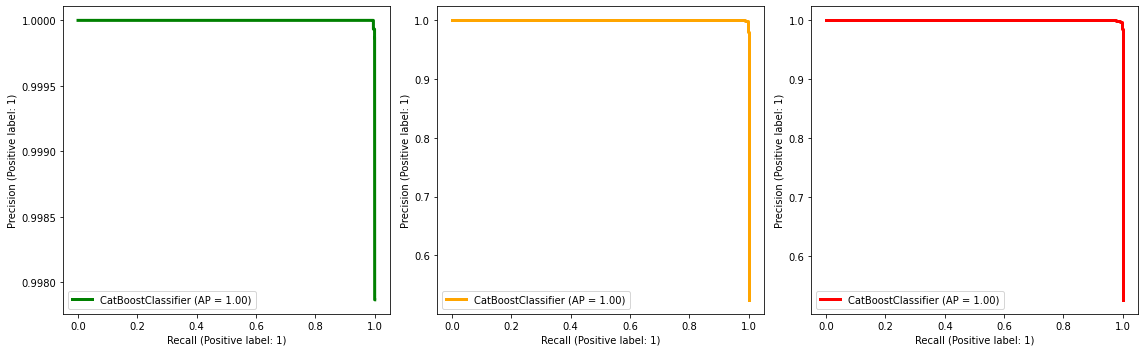

In [522]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(1,3, figsize=(16,5))
ax = ax.flatten()
PrecisionRecallDisplay.from_estimator(cat_tuned, X_train, y_train, color='green', lw=3, ax=ax[0])
PrecisionRecallDisplay.from_estimator(cat_tuned, X_valid, y_valid, color='orange', lw=3, ax=ax[1])
PrecisionRecallDisplay.from_estimator(cat_tuned, X_test, y_test, color='red', lw=3, ax=ax[2])
plt.tight_layout()
plt.show()

In [119]:
from catboost import cv

scores = cv(train_pool,
            params_model,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.9967454008
bestIteration = 40

Training on fold [1/3]

bestTest = 0.9966964897
bestIteration = 54

Training on fold [2/3]

bestTest = 0.9966868442
bestIteration = 3



In [124]:
print(f"Test mean cv score: {scores['test-Accuracy-mean'].mean():.4f}, train mean cv score: {scores['train-Accuracy-mean'].mean():.4f}")

Test mean cv score: 0.9963, train mean cv score: 0.9966


In [523]:
cat_tuned.save_model('cat_model')

In [524]:
cat_tuned.load_model('cat_model')
accuracy_score(y_test, cat_tuned.predict_proba(X_test)[:,1] >= thresholds[ix])

0.9975946547884187

#### Strange results with subject feature, let's make some stat tests. Looks like some target leakage.

In [85]:
from scipy import stats

def categorical_stats(df=df, target='target', alpha=0.05, sample_size=500):
    data = df.copy().sample(sample_size)
    columns_to_analize = ['subject']
    weak_list = []
    for factor in columns_to_analize:
        if factor == target:
            continue
        print(f'{factor}')
        table = pd.crosstab(data[factor], data[target])
        p_value = stats.chi2_contingency(table, correction=False)[1]
        if p_value < alpha:
            print(f'Feature "{factor}" has statistical impact on target. P-value: {p_value:.6f}')
        else:
            weak_list.append(factor)
    if len(weak_list) > 0:
        print(f'Statistically weak categorical features: ', *weak_list)

In [92]:
categorical_stats(sample_size=1000)

subject
Feature "subject" has statistical impact on target. P-value: 0.000000


### As an other approach: use LatentDirichletAllocation to extract numerical features from text feature and train boosting model

In [454]:
X, y = pd.DataFrame(data=df['text'].values.reshape(-1,1), columns=['text']), df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, stratify=y_train,
                                                      random_state=seed)
print(f'Train size: {X_train.shape[0]}, validation size: {X_valid.shape[0]}, Test size: {X_test.shape[0]}.')

Train size: 28622, validation size: 5051, Test size: 11225.


In [390]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from lightgbm import LGBMClassifier

In [391]:
class CountLDA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=5, learning_method='batch', max_features=1000, stop_words='english',
                 n_jobs=-1, random_state=seed): # max_iter=10 as default
        self.n_components = n_components
        self.learning_method = learning_method
        self.max_features = max_features
        self.stop_words = stop_words
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.pipe = None
        
    def fit(self, X, y=None):
        self.pipe = make_pipeline(CountVectorizer(stop_words=self.stop_words, max_features=self.max_features),
                                  LatentDirichletAllocation(n_components=self.n_components,
                                                            learning_method=self.learning_method,
                                                            n_jobs=self.n_jobs,
                                                            random_state=self.random_state)).fit(X['text'].values)
        return self
        
    def transform(self, X):
        X_ = np.zeros((X.shape[0], self.n_components))
        for i in range(X_.shape[0]):
            X_[i, :] = self.pipe.transform(X.values[i])
        return pd.DataFrame(data=X_, columns=[f'text_{i}' for i in range(self.n_components)], index=X.index)

In [392]:
model_params = {
                'objective': 'binary', # cross_entropy
                'n_estimators': 1000,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': seed,
}
fit_params = {'lgbmclassifier__early_stopping_rounds': 10,  
              'lgbmclassifier__eval_set': [(X_valid, y_valid)],  
              'lgbmclassifier__eval_metric': 'accuracy',
              'lgbmclassifier__verbose': False
             }

def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'reg_alpha': trial.suggest_float('reg_alpha', 1., 5.),
                    'reg_lambda': trial.suggest_float('reg_lambda', 1., 5.),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 265),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                    'max_bin': trial.suggest_int('max_bin', 60, 260),
                    'min_child_samples': trial.suggest_int('min_child_samples', 120, 260),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt']),
                    }
    count_lda_params = {
                        'n_components': trial.suggest_int('n_components', 5, 50),
                        'learning_method': trial.suggest_categorical('learning_method', ['batch', 'online']),
                        'max_features': trial.suggest_int('max_features', 3000, 10000)
                        }
    param_trials.update(model_params)
    opt_model = make_pipeline(Preprocessor(stop=stop, lemma=False),
                              CountLDA(**count_lda_params),
                              LGBMClassifier(**param_trials))
    
    opt_model.fit(X_train, y_train, **fit_params) # remove early stopping as it is not transformed during pipe eval!
    
    y_pred = opt_model.predict(X_valid)
    score = accuracy_score(y_valid, y_pred)
    
    return score

#### That's faster

In [455]:
%%time
init_pipe = make_pipeline(Preprocessor(stop=stop, lemma=False),
                          CountLDA(n_components=18, max_features=5000))

X_train = init_pipe.fit_transform(X_train)
X_valid = init_pipe.transform(X_valid)
X_test = init_pipe.transform(X_test)

In [398]:
fit_params = {'early_stopping_rounds': 10,  
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': 'accuracy',
              'verbose': False
             }

def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'reg_alpha': trial.suggest_float('reg_alpha', 1., 5.),
                    'reg_lambda': trial.suggest_float('reg_lambda', 1., 5.),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 265),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                    'max_bin': trial.suggest_int('max_bin', 60, 260),
                    'min_child_samples': trial.suggest_int('min_child_samples', 120, 260),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt']),
                    }

    param_trials.update(model_params)
    opt_model = LGBMClassifier(**param_trials)
    
    opt_model.fit(X_train, y_train, **fit_params)
    
    y_pred = opt_model.predict(X_valid)
    score = accuracy_score(y_valid, y_pred)
    
    return score

In [400]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=300, timeout=2000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2022-05-17 22:51:31,303] A new study created in memory with name: no-name-9d2c73c0-c20e-4f46-8d8f-7e011e89bdc7
[I 2022-05-17 22:51:31,429] Trial 0 finished with value: 0.9297168877450009 and parameters: {'max_depth': 5, 'learning_rate': 0.4758500101408589, 'reg_alpha': 3.9279757672456204, 'reg_lambda': 3.3946339367881464, 'num_leaves': 58, 'subsample': 0.40919616423534183, 'colsample_bytree': 0.3406585285177396, 'max_bin': 234, 'min_child_samples': 204, 'min_child_weight': 0.07109918520180851, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.9297168877450009.
[I 2022-05-17 22:51:31,769] Trial 1 finished with value: 0.935062363888339 and parameters: {'max_depth': 8, 'learning_rate': 0.11404616423235531, 'reg_alpha': 1.7272998688284025, 'reg_lambda': 1.7336180394137353, 'num_leaves': 94, 'subsample': 0.6673295021425665, 'colsample_bytree': 0.602361513049481, 'max_bin': 118, 'min_child_samples': 206, 'min_child_weight': 0.01480989220455214, 'boosting_type': 'gbdt'}. Best is tria

[I 2022-05-17 22:51:36,580] Trial 17 finished with value: 0.9366462086715502 and parameters: {'max_depth': 9, 'learning_rate': 0.34476677026521246, 'reg_alpha': 3.390996022278293, 'reg_lambda': 4.518397905115924, 'num_leaves': 216, 'subsample': 0.90309157793545, 'colsample_bytree': 0.8196669235529023, 'max_bin': 259, 'min_child_samples': 182, 'min_child_weight': 0.04615627215173064, 'boosting_type': 'gbdt'}. Best is trial 10 with value: 0.9382300534547614.
[I 2022-05-17 22:51:36,729] Trial 18 finished with value: 0.9297168877450009 and parameters: {'max_depth': 7, 'learning_rate': 0.4712753544759949, 'reg_alpha': 2.4341210737767547, 'reg_lambda': 3.7180289100264416, 'num_leaves': 108, 'subsample': 0.784999501791066, 'colsample_bytree': 0.9496720077630106, 'max_bin': 211, 'min_child_samples': 144, 'min_child_weight': 0.028518052359784878, 'boosting_type': 'gbdt'}. Best is trial 10 with value: 0.9382300534547614.
[I 2022-05-17 22:51:37,120] Trial 19 finished with value: 0.931102751930310

[I 2022-05-17 22:51:42,058] Trial 35 finished with value: 0.930706790734508 and parameters: {'max_depth': 9, 'learning_rate': 0.01071050577844923, 'reg_alpha': 2.4710018622149983, 'reg_lambda': 4.103440976334921, 'num_leaves': 153, 'subsample': 0.7285832157790222, 'colsample_bytree': 0.7595246923337587, 'max_bin': 146, 'min_child_samples': 174, 'min_child_weight': 0.06921837154097298, 'boosting_type': 'gbdt'}. Best is trial 32 with value: 0.9384280340526628.
[I 2022-05-17 22:51:42,293] Trial 36 finished with value: 0.9301128489408038 and parameters: {'max_depth': 8, 'learning_rate': 0.39721505920814104, 'reg_alpha': 4.764845616446396, 'reg_lambda': 4.38671957974568, 'num_leaves': 204, 'subsample': 0.9619867434841786, 'colsample_bytree': 0.6943148558505254, 'max_bin': 240, 'min_child_samples': 197, 'min_child_weight': 0.03356481464985732, 'boosting_type': 'goss'}. Best is trial 32 with value: 0.9384280340526628.
[I 2022-05-17 22:51:42,701] Trial 37 finished with value: 0.937438131063155

[I 2022-05-17 22:51:48,577] Trial 53 finished with value: 0.9384280340526628 and parameters: {'max_depth': 8, 'learning_rate': 0.09646843656241774, 'reg_alpha': 2.2414585393990394, 'reg_lambda': 4.629517378995964, 'num_leaves': 142, 'subsample': 0.8519151685861435, 'colsample_bytree': 0.9263933465166955, 'max_bin': 182, 'min_child_samples': 152, 'min_child_weight': 0.02687838840332296, 'boosting_type': 'gbdt'}. Best is trial 32 with value: 0.9384280340526628.
[I 2022-05-17 22:51:49,283] Trial 54 finished with value: 0.9336764997030291 and parameters: {'max_depth': 8, 'learning_rate': 0.0919851239305233, 'reg_alpha': 2.1913903408922875, 'reg_lambda': 4.42458333830317, 'num_leaves': 139, 'subsample': 0.9169143289641694, 'colsample_bytree': 0.9266403227461388, 'max_bin': 155, 'min_child_samples': 160, 'min_child_weight': 0.029508189941258364, 'boosting_type': 'gbdt'}. Best is trial 32 with value: 0.9384280340526628.
[I 2022-05-17 22:51:49,784] Trial 55 finished with value: 0.9352603444862

[I 2022-05-17 22:52:03,435] Trial 71 finished with value: 0.9374381310631558 and parameters: {'max_depth': 9, 'learning_rate': 0.07932683768026155, 'reg_alpha': 1.7532398306230539, 'reg_lambda': 3.944189705757407, 'num_leaves': 179, 'subsample': 0.9247175916772211, 'colsample_bytree': 0.9065096472183669, 'max_bin': 185, 'min_child_samples': 142, 'min_child_weight': 0.0321139618130122, 'boosting_type': 'gbdt'}. Best is trial 66 with value: 0.9406058206295783.
[I 2022-05-17 22:52:03,875] Trial 72 finished with value: 0.9386260146505643 and parameters: {'max_depth': 9, 'learning_rate': 0.11242666662613417, 'reg_alpha': 2.40050348699913, 'reg_lambda': 3.9512925166436066, 'num_leaves': 165, 'subsample': 0.8976268936171294, 'colsample_bytree': 0.8530051045682729, 'max_bin': 166, 'min_child_samples': 136, 'min_child_weight': 0.04455310746041996, 'boosting_type': 'gbdt'}. Best is trial 66 with value: 0.9406058206295783.
[I 2022-05-17 22:52:05,007] Trial 73 finished with value: 0.93684418926945

[I 2022-05-17 22:52:17,008] Trial 89 finished with value: 0.9368441892694516 and parameters: {'max_depth': 9, 'learning_rate': 0.15663417772330712, 'reg_alpha': 2.652560332306532, 'reg_lambda': 4.51415430280561, 'num_leaves': 241, 'subsample': 0.7542670564000518, 'colsample_bytree': 0.666633243438831, 'max_bin': 193, 'min_child_samples': 124, 'min_child_weight': 0.02065245869117375, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:52:17,419] Trial 90 finished with value: 0.9380320728568601 and parameters: {'max_depth': 8, 'learning_rate': 0.1270907029290516, 'reg_alpha': 2.749586223758174, 'reg_lambda': 3.7821161757950836, 'num_leaves': 223, 'subsample': 0.7312179962364682, 'colsample_bytree': 0.7172537010850084, 'max_bin': 177, 'min_child_samples': 129, 'min_child_weight': 0.03427910358792859, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:52:18,249] Trial 91 finished with value: 0.9366462086715502

[I 2022-05-17 22:52:29,940] Trial 107 finished with value: 0.9358542862799446 and parameters: {'max_depth': 9, 'learning_rate': 0.03683996114898729, 'reg_alpha': 1.7150712446220895, 'reg_lambda': 3.766087987245645, 'num_leaves': 184, 'subsample': 0.8261538452746335, 'colsample_bytree': 0.7401183827794289, 'max_bin': 147, 'min_child_samples': 142, 'min_child_weight': 0.03029530067563794, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:52:31,955] Trial 108 finished with value: 0.937042169867353 and parameters: {'max_depth': 9, 'learning_rate': 0.020979410775497205, 'reg_alpha': 3.0115240304768953, 'reg_lambda': 3.857519884993472, 'num_leaves': 200, 'subsample': 0.740458150683313, 'colsample_bytree': 0.8669569228774943, 'max_bin': 154, 'min_child_samples': 135, 'min_child_weight': 0.0397790504878983, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:52:32,224] Trial 109 finished with value: 0.93011284894

[I 2022-05-17 22:52:40,265] Trial 125 finished with value: 0.9382300534547614 and parameters: {'max_depth': 9, 'learning_rate': 0.1715116148790081, 'reg_alpha': 2.308533824060831, 'reg_lambda': 4.431029722537283, 'num_leaves': 169, 'subsample': 0.45979660228448166, 'colsample_bytree': 0.8038843361221979, 'max_bin': 150, 'min_child_samples': 143, 'min_child_weight': 0.009061497637904724, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:52:40,642] Trial 126 finished with value: 0.9372401504652544 and parameters: {'max_depth': 9, 'learning_rate': 0.1159898796245299, 'reg_alpha': 1.8462838174136382, 'reg_lambda': 4.609664162184291, 'num_leaves': 192, 'subsample': 0.5393457217056032, 'colsample_bytree': 0.7325047266102801, 'max_bin': 162, 'min_child_samples': 138, 'min_child_weight': 0.008886302391034204, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:52:41,235] Trial 127 finished with value: 0.937438131

[I 2022-05-17 22:52:49,312] Trial 143 finished with value: 0.9382300534547614 and parameters: {'max_depth': 9, 'learning_rate': 0.09210789465408364, 'reg_alpha': 2.385542915347333, 'reg_lambda': 1.1830806113600354, 'num_leaves': 159, 'subsample': 0.8948027465134457, 'colsample_bytree': 0.8572312338518184, 'max_bin': 179, 'min_child_samples': 130, 'min_child_weight': 0.047701435028910374, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:52:49,780] Trial 144 finished with value: 0.9380320728568601 and parameters: {'max_depth': 9, 'learning_rate': 0.1374549706102193, 'reg_alpha': 2.0188228541760385, 'reg_lambda': 4.557208819160307, 'num_leaves': 191, 'subsample': 0.9266718379072977, 'colsample_bytree': 0.8757648874245012, 'max_bin': 152, 'min_child_samples': 127, 'min_child_weight': 0.09639972473082492, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:52:50,477] Trial 145 finished with value: 0.939021975

[I 2022-05-17 22:53:00,601] Trial 161 finished with value: 0.9378340922589586 and parameters: {'max_depth': 9, 'learning_rate': 0.0627003813341752, 'reg_alpha': 2.3642687377453866, 'reg_lambda': 4.276291243354908, 'num_leaves': 189, 'subsample': 0.9167045346263629, 'colsample_bytree': 0.8204700354546183, 'max_bin': 158, 'min_child_samples': 139, 'min_child_weight': 0.040440170699838365, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:01,635] Trial 162 finished with value: 0.9400118788358741 and parameters: {'max_depth': 9, 'learning_rate': 0.04770232031549679, 'reg_alpha': 1.9487654752490813, 'reg_lambda': 2.305095673561208, 'num_leaves': 217, 'subsample': 0.9767288718951893, 'colsample_bytree': 0.8057840868417309, 'max_bin': 169, 'min_child_samples': 142, 'min_child_weight': 0.029766291607612235, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:02,224] Trial 163 finished with value: 0.94100178

[I 2022-05-17 22:53:14,978] Trial 179 finished with value: 0.9388239952484656 and parameters: {'max_depth': 8, 'learning_rate': 0.07095309265934949, 'reg_alpha': 2.1278285561109276, 'reg_lambda': 1.642362619399669, 'num_leaves': 209, 'subsample': 0.32692952273815856, 'colsample_bytree': 0.4168259012641943, 'max_bin': 163, 'min_child_samples': 151, 'min_child_weight': 0.03188606860765705, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:15,609] Trial 180 finished with value: 0.9400118788358741 and parameters: {'max_depth': 9, 'learning_rate': 0.08663341325109232, 'reg_alpha': 2.4446530971953075, 'reg_lambda': 2.690329813517563, 'num_leaves': 197, 'subsample': 0.3874124120132819, 'colsample_bytree': 0.7836394111672349, 'max_bin': 176, 'min_child_samples': 122, 'min_child_weight': 0.04807666105981297, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:16,338] Trial 181 finished with value: 0.93941793

[I 2022-05-17 22:53:25,142] Trial 197 finished with value: 0.9356563056820432 and parameters: {'max_depth': 9, 'learning_rate': 0.09483989501733536, 'reg_alpha': 2.272060745642723, 'reg_lambda': 2.196867799603041, 'num_leaves': 188, 'subsample': 0.3080807080458736, 'colsample_bytree': 0.8641535786604239, 'max_bin': 185, 'min_child_samples': 122, 'min_child_weight': 0.05453057567024928, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:25,513] Trial 198 finished with value: 0.9328845773114235 and parameters: {'max_depth': 9, 'learning_rate': 0.11335783690387438, 'reg_alpha': 2.360280399868228, 'reg_lambda': 2.6746335865767956, 'num_leaves': 184, 'subsample': 0.9506502274289249, 'colsample_bytree': 0.8190745363841843, 'max_bin': 177, 'min_child_samples': 126, 'min_child_weight': 0.0523998383064368, 'boosting_type': 'goss'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:25,936] Trial 199 finished with value: 0.93921995644

[I 2022-05-17 22:53:37,486] Trial 215 finished with value: 0.9380320728568601 and parameters: {'max_depth': 9, 'learning_rate': 0.059481596697123475, 'reg_alpha': 2.3436802099390697, 'reg_lambda': 4.842764072917748, 'num_leaves': 157, 'subsample': 0.3773848234740705, 'colsample_bytree': 0.7706028981655586, 'max_bin': 155, 'min_child_samples': 132, 'min_child_weight': 0.028013586587884665, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:38,595] Trial 216 finished with value: 0.9378340922589586 and parameters: {'max_depth': 9, 'learning_rate': 0.03130918750861352, 'reg_alpha': 1.9055469594161163, 'reg_lambda': 1.8226224661654964, 'num_leaves': 226, 'subsample': 0.3882956910561958, 'colsample_bytree': 0.7511263398892242, 'max_bin': 170, 'min_child_samples': 120, 'min_child_weight': 0.023558097128662178, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:39,187] Trial 217 finished with value: 0.93724

[I 2022-05-17 22:53:48,482] Trial 233 finished with value: 0.9366462086715502 and parameters: {'max_depth': 9, 'learning_rate': 0.13198893792836758, 'reg_alpha': 2.3875909961148243, 'reg_lambda': 4.478239518175063, 'num_leaves': 182, 'subsample': 0.7976997405926389, 'colsample_bytree': 0.8376874784827875, 'max_bin': 177, 'min_child_samples': 129, 'min_child_weight': 0.09028979600040463, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:49,414] Trial 234 finished with value: 0.9384280340526628 and parameters: {'max_depth': 9, 'learning_rate': 0.0763629958342858, 'reg_alpha': 1.187078113169248, 'reg_lambda': 1.3893922245841717, 'num_leaves': 178, 'subsample': 0.8085439939580987, 'colsample_bytree': 0.7860242850159243, 'max_bin': 172, 'min_child_samples': 139, 'min_child_weight': 0.023165992626114563, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:49,898] Trial 235 finished with value: 0.939219956

[I 2022-05-17 22:53:58,110] Trial 251 finished with value: 0.9378340922589586 and parameters: {'max_depth': 9, 'learning_rate': 0.12169278789666818, 'reg_alpha': 1.086290930544858, 'reg_lambda': 4.521802301697934, 'num_leaves': 163, 'subsample': 0.822058195341806, 'colsample_bytree': 0.8216635881276099, 'max_bin': 170, 'min_child_samples': 143, 'min_child_weight': 0.01585938105873242, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:58,755] Trial 252 finished with value: 0.9368441892694516 and parameters: {'max_depth': 9, 'learning_rate': 0.06107366873990764, 'reg_alpha': 1.14650824785594, 'reg_lambda': 4.564559827190288, 'num_leaves': 33, 'subsample': 0.7953241238529551, 'colsample_bytree': 0.7899605828166941, 'max_bin': 173, 'min_child_samples': 140, 'min_child_weight': 0.024165145556916557, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:53:59,336] Trial 253 finished with value: 0.9376361116610

[I 2022-05-17 22:54:08,390] Trial 269 finished with value: 0.9384280340526628 and parameters: {'max_depth': 9, 'learning_rate': 0.09683526145449112, 'reg_alpha': 1.0956502877989374, 'reg_lambda': 4.850838499682286, 'num_leaves': 153, 'subsample': 0.7710528577150189, 'colsample_bytree': 0.7560176068853277, 'max_bin': 178, 'min_child_samples': 135, 'min_child_weight': 0.016362357393368256, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:54:08,985] Trial 270 finished with value: 0.9394179370421699 and parameters: {'max_depth': 9, 'learning_rate': 0.0685323659238833, 'reg_alpha': 2.503599352748428, 'reg_lambda': 2.8497270363861915, 'num_leaves': 157, 'subsample': 0.3962650321473109, 'colsample_bytree': 0.7755572220590125, 'max_bin': 182, 'min_child_samples': 130, 'min_child_weight': 0.05321956658288678, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:54:09,545] Trial 271 finished with value: 0.935854286

[I 2022-05-17 22:54:18,860] Trial 287 finished with value: 0.9406058206295783 and parameters: {'max_depth': 9, 'learning_rate': 0.09634435671641359, 'reg_alpha': 2.263245965646827, 'reg_lambda': 4.659411728666051, 'num_leaves': 179, 'subsample': 0.7988777274946023, 'colsample_bytree': 0.7519159778618244, 'max_bin': 157, 'min_child_samples': 123, 'min_child_weight': 0.07886480317832475, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:54:19,269] Trial 288 finished with value: 0.9382300534547614 and parameters: {'max_depth': 9, 'learning_rate': 0.12722679758713037, 'reg_alpha': 2.2760509210109383, 'reg_lambda': 4.77065210318994, 'num_leaves': 176, 'subsample': 0.8134466606166586, 'colsample_bytree': 0.754158249769656, 'max_bin': 153, 'min_child_samples': 127, 'min_child_weight': 0.07269131892606434, 'boosting_type': 'gbdt'}. Best is trial 85 with value: 0.9423876460106909.
[I 2022-05-17 22:54:20,103] Trial 289 finished with value: 0.941001781825

Number of completed trials: 300
Best trial
Best score: 0.9423876460106909
Best params
max_depth: 9
learning_rate: 0.1105041378974716
reg_alpha: 2.4120921402225255
reg_lambda: 3.799197888002267
num_leaves: 207
subsample: 0.7950757738745801
colsample_bytree: 0.7609697638862005
max_bin: 175
min_child_samples: 125
min_child_weight: 0.03461940814555304
boosting_type: gbdt


#### Fine-tunning takes too long, just check base results first to decide whether it is reasnable approach.

#### BASE

In [230]:
%%time
pipe = make_pipeline(Preprocessor(stop=stop, lemma=False),
                     CountLDA(n_components=12),
                     LGBMClassifier(verbose=-1), verbose=True).fit(X_train, y_train)

[Pipeline] ...... (step 1 of 3) Processing preprocessor, total= 1.3min
[Pipeline] .......... (step 2 of 3) Processing countlda, total= 1.5min
[Pipeline] .... (step 3 of 3) Processing lgbmclassifier, total=   0.1s
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5354
           1       0.93      0.93      0.93      5871

    accuracy                           0.93     11225
   macro avg       0.93      0.93      0.93     11225
weighted avg       0.93      0.93      0.93     11225

CPU times: total: 2min 51s
Wall time: 3min 41s


In [231]:
lda_train_pred = pipe.predict(X_train)
lda_test_pred = pipe.predict(X_test)
lda_train_probs = pipe.predict_proba(X_train)[:,1]
lda_test_probs = pipe.predict_proba(X_test)[:,1]

report(y_train, lda_train_pred, y_test, lda_test_pred, lda_train_probs, lda_test_probs)

Train
               precision    recall  f1-score   support

           0      0.942     0.945     0.943     13654
           1      0.950     0.947     0.948     14968

    accuracy                          0.946     28622
   macro avg      0.946     0.946     0.946     28622
weighted avg      0.946     0.946     0.946     28622

Test
               precision    recall  f1-score   support

           0      0.928     0.927     0.927      5354
           1      0.933     0.934     0.934      5871

    accuracy                          0.931     11225
   macro avg      0.930     0.930     0.930     11225
weighted avg      0.931     0.931     0.931     11225

Train ROC_AUC: 0.989, Test ROC_AUC: 0.979
Confusion Matrix 
 col_0      0     1
target            
0       4962   392
1        387  5484


In [232]:
precision, recall, thresholds = precision_recall_curve(y_test, lda_test_probs)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.525551, F-Score=0.934, Precision=0.938, Recall=0.930


#### LGBM tunned

In [457]:
import lightgbm

alpha = 0.95
learning_rate_min = 0.01
learning_rate_start = 0.1

fit_params = {'early_stopping_rounds': 20,  
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': 'accuracy',
              'verbose': False,
             }

model_params = {
                'objective': 'binary', # cross_entropy
                'n_estimators': 2000,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': seed,
                'max_depth': 9,
                'learning_rate': 0.1105041378974716,
                'reg_alpha': 2.4120921402225255,
                'reg_lambda': 3.799197888002267,
                'num_leaves': 207,
                'subsample': 0.7950757738745801,
                'colsample_bytree': 0.7609697638862005,
                'max_bin': 175,
                'min_child_samples': 125,
                'min_child_weight': 0.03461940814555304,
                'boosting_type': 'goss',
}

In [460]:
lgbm = LGBMClassifier(**model_params)
lgbm.fit(X_train, 
         y_train,
         callbacks=[lightgbm.reset_parameter(learning_rate=lambda current_round: max(learning_rate_min, learning_rate_start * np.power(alpha, current_round)))],
         **fit_params)

lgbm_train_pred = lgbm.predict(X_train)
lgbm_test_pred = lgbm.predict(X_test)

lgbm_train_probs = lgbm.predict_proba(X_train)[:,1]
lgbm_test_probs = lgbm.predict_proba(X_test)[:,1]

report(y_train, lgbm_train_pred, y_test, lgbm_test_pred, lgbm_train_probs, lgbm_test_probs)

Train
               precision    recall  f1-score   support

           0      0.958     0.962     0.960     13654
           1      0.965     0.962     0.963     14968

    accuracy                          0.962     28622
   macro avg      0.962     0.962     0.962     28622
weighted avg      0.962     0.962     0.962     28622

Test
               precision    recall  f1-score   support

           0      0.938     0.931     0.934      5354
           1      0.937     0.944     0.941      5871

    accuracy                          0.938     11225
   macro avg      0.938     0.937     0.937     11225
weighted avg      0.938     0.938     0.938     11225

Train ROC_AUC: 0.993, Test ROC_AUC: 0.984
Confusion Matrix 
 col_0      0     1
target            
0       4983   371
1        330  5541


In [461]:
precision, recall, thresholds = precision_recall_curve(y_test, lgbm_test_probs)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.460132, F-Score=0.941, Precision=0.932, Recall=0.950


In [462]:
accuracy_score(y_test, lgbm.predict_proba(X_test)[:,1] > thresholds[ix]) # set as default 0.5

0.9374610244988865

In [420]:
cross_validation(lgbm, X=X_train, y=y_train, scoring='accuracy', cv=5)

Меры правильности перекрекстной оценки: [0.94637555 0.93956332 0.93798043 0.93937806 0.93972746]
Точность перекретсной оценки: 0.941 +/- 0.003


array([0.94637555, 0.93956332, 0.93798043, 0.93937806, 0.93972746])

In [452]:
import joblib

joblib.dump(lgbm, 'lgbm_model.pkl')
lgbm = joblib.load('lgbm_model.pkl')

#### Some unnecessary experiment

In [440]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

X_fold, y_fold = pd.concat([X_train, X_valid], axis=0), pd.concat([y_train, y_valid], axis=0)
print(f'KFold size: {X_fold.shape}')

KFold size: (33673, 18)


In [442]:
def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote

In [443]:
test_results, train_roc, test_pred, train_f1, train_acc = [], [], [], [], []
skf = StratifiedKFold(n_splits=3)
lgbms = []

for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train, X_valid = X_fold.iloc[train_index, :], X_fold.iloc[valid_index, :]
    y_train, y_valid = y_fold.values[train_index], y_fold.values[valid_index]

    lgbm = LGBMClassifier(**model_params)
    fit_params = {'early_stopping_rounds': 20,  
                  'eval_set': [(X_valid, y_valid)],  
                  'eval_metric': 'accuracy',
                  'verbose': False
                  }
    lgbm.fit(X_train, 
             y_train,
             callbacks=[lightgbm.reset_parameter(learning_rate=lambda current_round: max(learning_rate_min, learning_rate_start * np.power(alpha, current_round)))],
             **fit_params)
    test_labels = lgbm.predict(X_test)
    test_pred.append(test_labels)
    
    train_proba = lgbm.predict_proba(X_train)[:,1]
    train_roc.append(roc_auc_score(y_train, train_proba))
    
    train_labels = lgbm.predict(X_train)
    train_f1.append(f1_score(y_train, train_labels))
    train_acc.append(accuracy_score(y_train, train_labels))
    
    pred_test = lgbm.predict_proba(X_test)[:,1]
    test_results.append(pred_test)
    print(classification_report(y_test, test_labels, digits=3), '\n', '='*30)
    lgbms.append(lgbm)

final_test = np.array(test_results).mean(axis=0)
test_pred = vote(test_pred, weights=[1.,1.,1.])

              precision    recall  f1-score   support

           0      0.934     0.928     0.931      5354
           1      0.934     0.940     0.937      5871

    accuracy                          0.934     11225
   macro avg      0.934     0.934     0.934     11225
weighted avg      0.934     0.934     0.934     11225
 
              precision    recall  f1-score   support

           0      0.931     0.930     0.931      5354
           1      0.936     0.938     0.937      5871

    accuracy                          0.934     11225
   macro avg      0.934     0.934     0.934     11225
weighted avg      0.934     0.934     0.934     11225
 
              precision    recall  f1-score   support

           0      0.937     0.925     0.931      5354
           1      0.932     0.943     0.938      5871

    accuracy                          0.934     11225
   macro avg      0.934     0.934     0.934     11225
weighted avg      0.934     0.934     0.934     11225
 


In [444]:
print(f'train mean accuracy: {np.array(train_acc).mean():.4f}, test accuracy: {accuracy_score(y_test, test_pred):.4f}')
print(f'train mean f1: {np.array(train_f1).mean():.4f}, test f1: {f1_score(y_test, test_pred):.4f}')
print(f'train mean auc: {np.array(train_roc).mean():.4f}, test auc: {roc_auc_score(y_test, final_test):.4f}')

train mean accuracy: 0.9618, test accuracy: 0.9358
train mean f1: 0.9634, test f1: 0.9388
train mean auc: 0.9932, test auc: 0.9841


### Bert PyTorch approach

In [348]:
import torch
import transformers
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer
from transformers import TrainingArguments, LongformerConfig, LongformerModel
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import TensorDataset, DataLoader
from tqdm.autonotebook import tqdm
from torchsummary import summary

In [324]:
LR = 1e-4
PATH = 'model.pth'
MAX_SEQ_LEN = 512
BATCH_SIZE = 32
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096', max_length = 1024)
clear_output()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using {device.upper()} device')

Currently using CUDA device


In [236]:
fake = pd.read_csv('Fake.csv')
truth = pd.read_csv('True.csv')

fake['target'] = 1
truth['target'] = 0

df = pd.concat([fake, truth], axis=0).sample(frac=1).reset_index(drop=True)
df.head()

,title,text,subject,date,target
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


In [326]:
X = df[['text', 'target']]
X_train, X_test = train_test_split(X, test_size=0.25, shuffle=True, random_state=seed)
X_train, X_valid = train_test_split(X_train, test_size=0.15, shuffle=True, random_state=seed)
print(f'Train size: {X_train.shape[0]}, validation size: {X_valid.shape[0]}, Test size: {X_test.shape[0]}.')

Train size: 28622, validation size: 5051, Test size: 11225.


In [332]:
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer(snow_stem(preprocessor(sent)), padding='max_length', truncation=True, max_length=1024)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [338]:
train_inputs, train_masks = preprocessing_for_bert(X_train['text'].values)
val_inputs, val_masks = preprocessing_for_bert(X_valid['text'].values)
test_inputs, test_masks = preprocessing_for_bert(X_test['text'].values)

In [362]:
from torch.utils.data import RandomSampler, SequentialSampler

train_labels = torch.tensor(X_train['target'].values)
val_labels = torch.tensor(X_valid['target'].values)
test_labels = torch.tensor(X_test['target'].values)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [358]:
class BertModel(nn.Module):
    def __init__(self, tune=False):
        super(BertModel, self).__init__()
        self.bert = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        # LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096',
        #                                                   gradient_checkpointing=False,
        #                                                   attention_window = 512)
        self.tune = tune
        for param in self.bert.parameters():
            param.requires_grad = tune
        self.classifier = nn.Sequential(nn.Linear(768, 768),  # self.bert.classifier
                                        nn.LeakyReLU(0.01, inplace=True), # nn.Conv1d 
                                        nn.Dropout(0.1),
                                        nn.Linear(768, 2)
                                        )
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [352]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    bert_classifier = BertModel(tune=False).to(device)

    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [478]:
import random
import time

loss_fn = nn.CrossEntropyLoss()  # ignore_index=0?

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()

            logits = model(b_input_ids, b_attn_mask)

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)

        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):

    model.eval()

    val_accuracy = []
    val_loss = []

    for _, batch in enumerate(tqdm(val_dataloader, leave=False)):
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [507]:
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
try:
    bert_classifier.load_state_dict(torch.load('bert_model.pth'))
    optimizer.load_state_dict(torch.load('optimizer.pth'))
    scheduler.load_state_dict(torch.load('scheduler.pth'))
except:
    print('Model dict not found')
train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |   20    |   0.247619   |     -      |     -     |   31.73  
   3    |   40    |   0.289228   |     -      |     -     |   29.89  
   3    |   60    |   0.246216   |     -      |     -     |   30.16  
   3    |   80    |   0.264763   |     -      |     -     |   30.01  
   3    |   100   |   0.265217   |     -      |     -     |   30.03  
   3    |   120   |   0.272468   |     -      |     -     |   30.08  
   3    |   140   |   0.270235   |     -      |     -     |   30.10  
   3    |   160   |   0.237262   |     -      |     -     |   30.12  
   3    |   180   |   0.249886   |     -      |     -     |   30.16  
   3    |   200   |   0.286647   |     -      |     -     |   30.28  
   3    |   220   |   0.263015   |     -      |     -     |   30.18  
   3    |   240   |   0.275372   |     -      |     -     |   30.19  


   3    |    -    |   0.255174   |  0.209725  |   92.26   |  1575.09 
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   4    |   20    |   0.234320   |     -      |     -     |   31.72  
   4    |   40    |   0.228715   |     -      |     -     |   30.28  
   4    |   60    |   0.231799   |     -      |     -     |   30.20  
   4    |   80    |   0.241537   |     -      |     -     |   30.19  
   4    |   100   |   0.240968   |     -      |     -     |   30.18  
   4    |   120   |   0.239866   |     -      |     -     |   30.19  
   4    |   140   |   0.253387   |     -      |     -     |   30.17  
   4    |   160   |   0.244229   |     -      |     -     |   30.18  
   4    |   180   |   0.230435   |     -      |     -     |   30.18  
   4    |   200   |   0.255062   |     -      |     -     |   30.18  
   4    |   220 

   4    |    -    |   0.237327   |  0.198599  |   92.74   |  1573.70 
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   5    |   20    |   0.231200   |     -      |     -     |   31.66  
   5    |   40    |   0.255960   |     -      |     -     |   30.15  
   5    |   60    |   0.239904   |     -      |     -     |   30.20  
   5    |   80    |   0.222387   |     -      |     -     |   30.21  
   5    |   100   |   0.232496   |     -      |     -     |   30.20  
   5    |   120   |   0.236879   |     -      |     -     |   30.18  
   5    |   140   |   0.236512   |     -      |     -     |   30.17  
   5    |   160   |   0.218788   |     -      |     -     |   30.17  
   5    |   180   |   0.222408   |     -      |     -     |   30.16  
   5    |   200   |   0.200851   |     -      |     -     |   30.16  
   5    |   220 

   5    |    -    |   0.231555   |  0.194727  |   92.86   |  1573.46 
----------------------------------------------------------------------


Training complete!


In [508]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):

    model.eval()

    all_logits = []

    for _, batch in enumerate(tqdm(test_dataloader, leave=False)):
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    all_logits = torch.cat(all_logits, dim=0)

    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [509]:
probs = bert_predict(bert_classifier, test_dataloader)

precision, recall, thresholds = precision_recall_curve(y_test, probs[:,1])
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.001674, F-Score=0.687, Precision=0.523, Recall=1.000


ROC_AUC: 0.4961
Confusion matrix, without normalization
[[   4 5350]
 [   0 5871]]


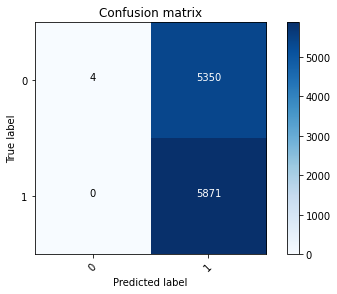

In [510]:
labels = probs[:,1] >= 0.001674
print(f'ROC_AUC: {roc_auc_score(y_test, probs[:,1]):.4f}')
cm = confusion_matrix(y_test, labels)
plot_confusion_matrix(cm, [0,1])
# very-very-very low threshold

In [511]:
evaluate(bert_classifier, test_dataloader)
# but accuracy is still fine and also without any overfitting (according to loss average values)

(0.2006957350972711, 92.85719373219374)

In [512]:
torch.save(bert_classifier.state_dict(), 'bert_model.pth')
torch.save(optimizer.state_dict(), 'optimizer.pth')
torch.save(scheduler.state_dict(), 'scheduler.pth')

### Bert for short term classification with convolutional layers and tensorflow

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
tf.random.set_seed(seed)

In [82]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11947926683255396710
xla_global_id: -1
]


In [81]:
tf.test.is_built_with_cuda()

True

In [80]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')

In [73]:
# restart notebook in conda env: 'conda create --name tf_gpu tensorflow-gpu' + text + hub + optimize
# or train model in colab or kaggle and use it here with CPU for inference

In [146]:
X, y = pd.DataFrame(data=df['text'].values.reshape(-1,1), columns=['text']), df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, stratify=y_train,
                                                      random_state=seed)
print(f'Train size: {X_train.shape[0]}, validation size: {X_valid.shape[0]}, Test size: {X_test.shape[0]}.')

Train size: 28622, validation size: 5051, Test size: 11225.


In [125]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['sequence_output']
    conv = tf.keras.layers.Conv1D(64, (2), activation='relu')(net)
    conv = tf.keras.layers.Conv1D(128, (2), activation='relu')(conv)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv) 
    drop = tf.keras.layers.Dropout(0.25)(pool)
    net = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(5e-5))(drop)
    net = tf.keras.layers.Dropout(0.25)(net)
    net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [127]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = seed

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE) 
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [136]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [144]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: v for i, v in enumerate(weights)}
class_weights

{0: 1.0481177676871247, 1: 0.9561063602351684}

In [137]:
checkpoint_path = '.'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.SparseCategoricalAccuracy('accuracy'),] 
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False),
             tf.keras.callbacks.ReduceLROnPlateau(patience=4),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir="logs"),
            ]

In [138]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
with tf.device('/gpu:0'):
    history = classifier_model.fit(train_ds, 
                                   epochs=epochs, 
                                   verbose=1, 
                                   validation_data=val_ds,
                                   class_weight=class_weights,
                                   callbacks=callbacks)

In [ ]:
#classifier_model.save(saved_model_path, include_optimizer=False)
classifier_model.evaluate(X_test, y_test)